# Setup

In [1]:
# disabling warnings
import warnings

# data wrangling
import pandas as pd

# data viz
import matplotlib.pyplot as plt

# merging multiple data frames
from functools import reduce

# automated time series analysis
import pmdarima as pm

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# ignoring warnings
warnings.filterwarnings('ignore')

# Topic Prediction

In [2]:
# import data
df_merged = pd.read_excel("output/lda_output.xlsx", index_col = 0)
number_topics = 6
topic_names = list(df_merged.columns.values[:number_topics])

## Predictors

In [3]:
# compute average topic distribution per month
df_merged['month_year'] = df_merged['date'].dt.to_period('M')
topic_distributions_monthly = df_merged.groupby('month_year', as_index = False)[topic_names].mean().copy()

# transform topic proportions to percentage points
topic_distributions_monthly.iloc[:, 1:8] = topic_distributions_monthly.iloc[:, 1:8] * 100

# convert date format
topic_distributions_monthly['month_year'] = topic_distributions_monthly['month_year'].dt.strftime('%Y-%m').add('-01')

In [4]:
# import monthly unemployment data
unemployment = pd.read_excel("other_data/unemployment_rate.xls", skiprows=10)
unemployment = unemployment.rename(columns={'UNRATE': 'unemployment', 'observation_date': 'month_year'})
unemployment = unemployment[(unemployment['month_year'] >= '2004-07-01') & (unemployment
                                                                    ['month_year'] <= '2017-01-01')]
unemployment['month_year'] = unemployment['month_year'].dt.strftime('%Y-%m-%d')

In [5]:
# import daily oil price data
oil = pd.read_csv("other_data/oil_prices.csv", skiprows = 6, parse_dates = ['Day'])
oil = oil.rename(columns = {'Europe Brent Spot Price FOB $/bbl': 'Brent', 
                          'Cushing OK WTI Spot Price FOB $/bbl': 'Cushing'})

# convert date format
oil['Day'] = pd.to_datetime(oil['Day'])
oil['month_year'] = oil['Day'].dt.to_period('M')
oil['month_year'] = oil['month_year'].dt.strftime('%Y-%m').add('-01')

# compute average monthly oil price
oil = oil.groupby('month_year', as_index = True)['Brent', 'Cushing'].mean().copy()
oil['oil'] = oil.mean(axis = 1)

# drop irrelevant columns
oil = oil.drop(['Brent', 'Cushing'], 1)

In [6]:
# import daily Dow Jones stock market data
stocks = pd.read_csv("other_data/HistoricalPricesDowJones.csv", usecols = ['Date', ' Close'], 
                     parse_dates = ['Date'])
stocks = stocks.rename(columns = {' Close': 'stocks'})

# convert date format
stocks['month_year'] = stocks['Date'].dt.to_period('M')
stocks['month_year'] = stocks['month_year'].dt.strftime('%Y-%m').add('-01')

# compute average monthly stock market index
stocks = stocks.groupby('month_year', as_index = True)['stocks'].mean().copy()

In [7]:
# merge data frames
data_frames = [topic_distributions_monthly, unemployment, oil, stocks]
time_series_df = reduce(lambda left, right: pd.merge(left, right, on = ['month_year'],
                                            how = 'inner'), data_frames)

# replace index with dates
time_series_df.index = pd.DatetimeIndex(time_series_df.month_year)
time_series_df.sort_index(inplace = True)
time_series_df = time_series_df.drop('month_year', 1)

time_series_df.astype(float).round(2).head(10)

,labour market,support system,politics,international role,defence,american dream,unemployment,oil,stocks
month_year,,,,,,,,,
2004-07-01,14.84,53.82,8.35,0.02,0.02,22.95,5.5,39.50,10152.09
2005-01-01,0.05,14.55,65.86,0.06,0.06,19.42,5.3,45.67,10539.51
2005-04-01,0.02,0.04,29.55,50.46,19.90,0.03,5.2,52.43,10283.19
2005-06-01,30.94,26.01,12.21,0.01,0.01,30.82,5.0,55.35,10486.68
2005-10-01,5.33,70.01,22.21,0.04,0.05,2.36,5.0,60.40,10324.31
2005-12-01,0.04,0.08,58.09,0.04,41.68,0.06,4.9,58.13,10827.79
2006-01-01,0.08,97.22,2.42,0.08,0.09,0.12,4.7,64.24,10872.48
2006-07-01,1.01,2.20,93.04,1.05,1.16,1.54,4.7,74.04,11032.53
2007-01-01,9.77,7.19,55.36,0.07,0.08,27.53,4.6,54.09,12512.89


## Time Series Analysis

In [8]:
# create train and test data
test_size = int(len(time_series_df) * 0.2)
train, test = time_series_df.iloc[:-test_size], time_series_df.iloc[-test_size:]

# standardise train data
def standardise_predictors(data):
    data = (data - data.mean()) / (data.std())
    return data

train_standardised = train.copy()
train_standardised.iloc[:, number_topics:] = standardise_predictors(train_standardised.iloc[:, number_topics:])

# standardise test data using train mean and train std
test_standardised = test.copy()
test_standardised.iloc[:, number_topics:] = (test_standardised.iloc[:, number_topics:] - train.iloc[:, number_topics:].
                                                      mean()) / (train.iloc[:, number_topics:].std())


### Model Taining

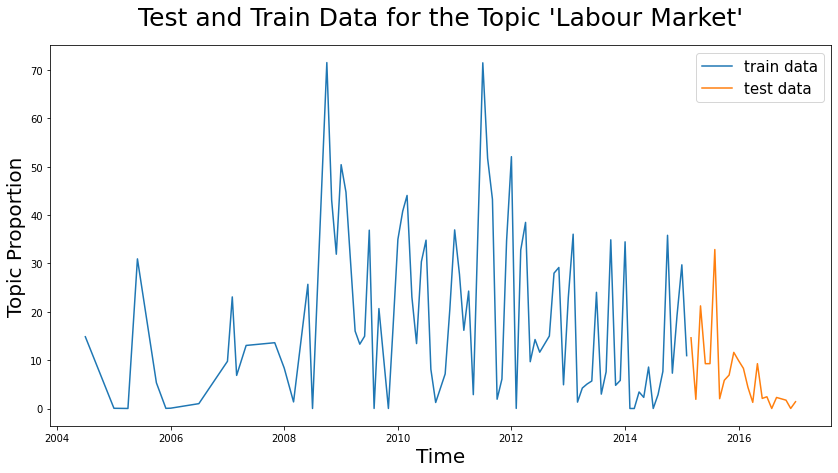

In [9]:
# plot test and train data for first topic (defence)
plt.rcParams['figure.figsize'] = [14, 7]

first_topic = topic_names[0]

fig, ax = plt.subplots(1, 1)
ax.plot(train_standardised[first_topic], label = "train data")
ax.plot(test_standardised[first_topic], label = "test data")
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Topic Proportion", fontsize = 20)
plt.legend(loc = "upper right", fontsize = 15)
plt.title("Test and Train Data for the Topic '" + first_topic.title() + "'", fontsize = 25, pad = 20)
plt.show()

In [10]:
def time_series(data_set, predictors):
    # create empty list
    models = []
    i = 0
    
    # loop through topics and run automated time series analysis
    for column in data_set.columns[:number_topics]:        
        model = pm.auto_arima(data_set[[column]] , 
                          exogenous = data_set[predictors],
                          start_p = 1, 
                          start_q = 1,
                          test = 'adf',       
                          max_p = 5,          
                          max_q = 5,          
                          m = 1,              
                          d = None,           
                          seasonal = False,   
                          start_P = 0, 
                          D = 0, 
                          trace = False,             # suppress output
                          error_action = 'ignore',
                          suppress_warnings = True, 
                          stepwise = True)
    
        # append model to list
        models.append(model)
    
        i = i + 1
        
    return models

In [11]:
# select predictors
predictors = ['unemployment', 'oil', 'stocks']

# train time series model
models_train = time_series(train_standardised, predictors)

### Forecasting

In [12]:
# forecast time series and compare to test data
def forecast_time_series(models):
    i = 0
    for model in models:
        # predict time series
        prediction, confint = model.predict(n_periods = test_size, 
                                    exogenous = test_standardised[predictors],
                                    return_conf_int = True)
    
        # create index for prediction
        index_prediction = pd.date_range(train_standardised.index[-1], periods = test_size, freq='MS')
    
        # add index to forecast and corresponding confidence interval 
        fitted_series = pd.Series(prediction, index = index_prediction)
        lower_series = pd.Series(confint[:, 0], index = index_prediction)
        upper_series = pd.Series(confint[:, 1], index = index_prediction)
    
        print("\nThis is the forecast of the topic '" + topic_names[i] + "':\n")
    
        # plot forecast
        plt.plot(time_series_df[topic_names[i]])
        plt.plot(fitted_series, color = 'red')
        plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color = 'k', 
                 alpha = .1)
        plt.title("Forecast of Topic '" + str(topic_names[i]).title() + "'", fontsize = 25, pad = 20)
        plt.show()
    
        i = i + 1


This is the forecast of the topic 'labour market':



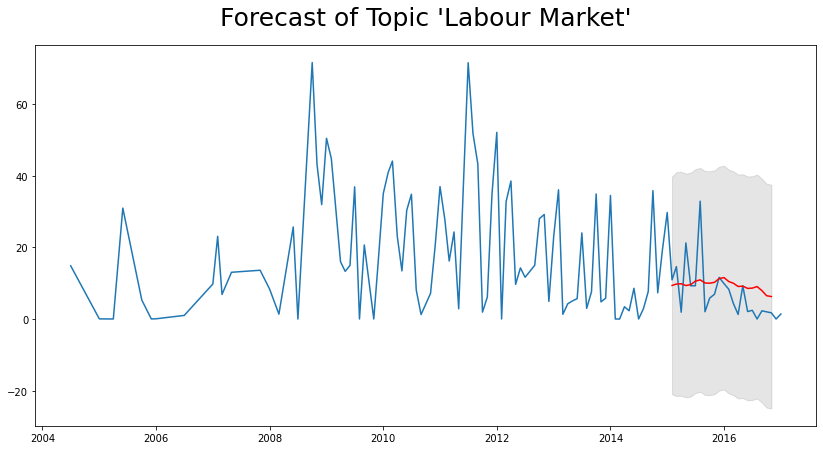


This is the forecast of the topic 'support system':



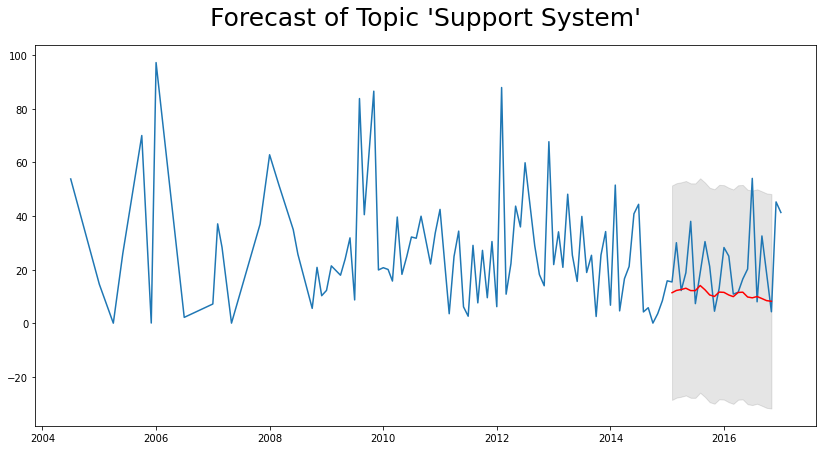


This is the forecast of the topic 'politics':



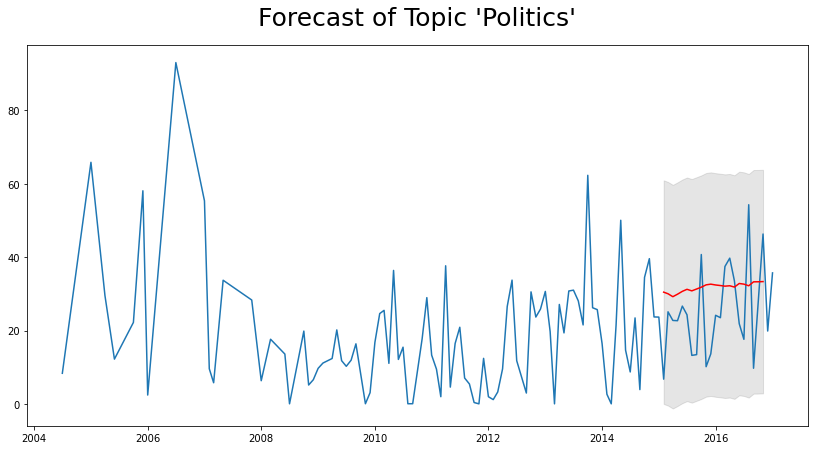


This is the forecast of the topic 'international role':



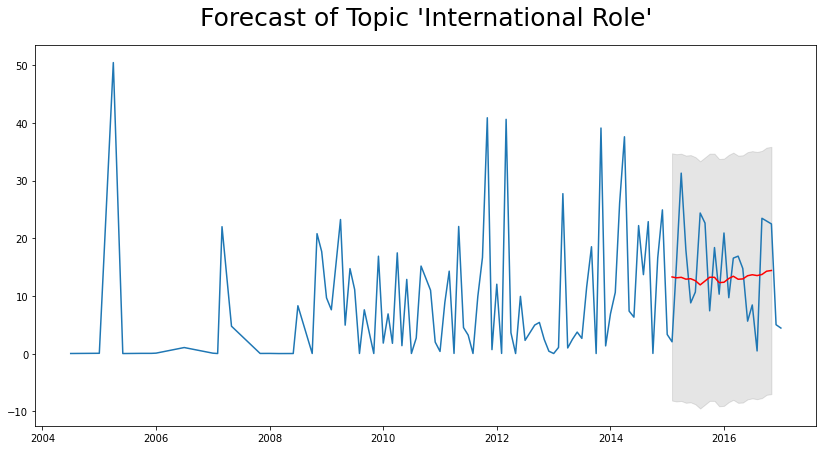


This is the forecast of the topic 'defence':



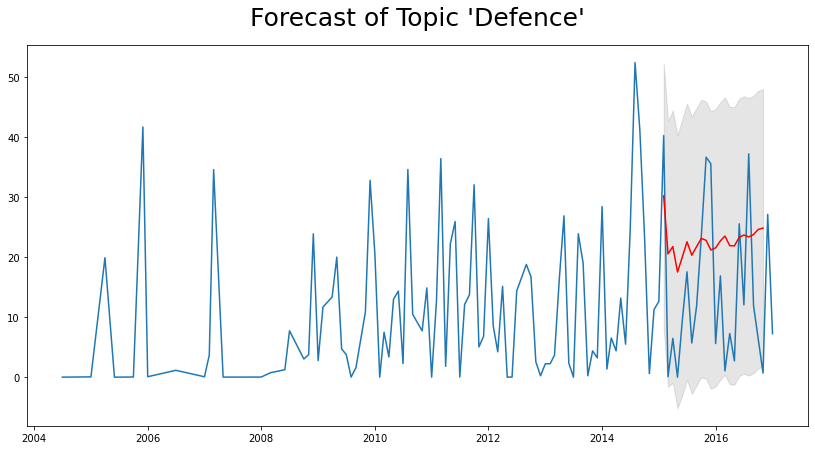


This is the forecast of the topic 'american dream':



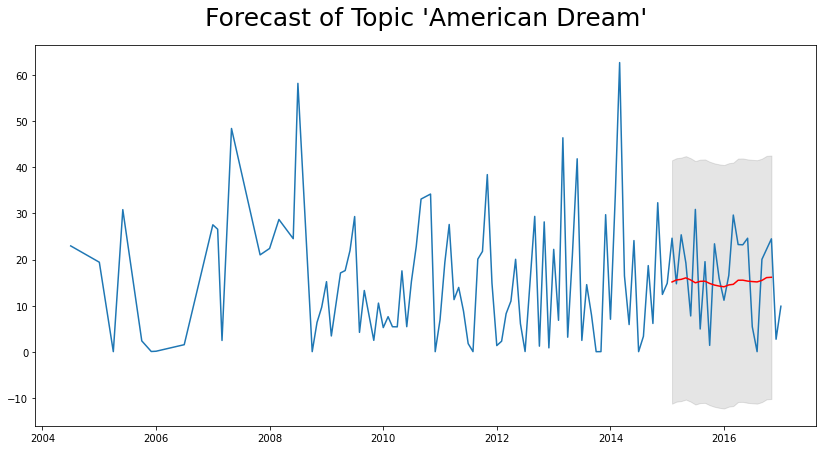

In [13]:
forecast_time_series(models_train)

### Diagnostics


These are the diagnostics plots of the topic 'labour market':



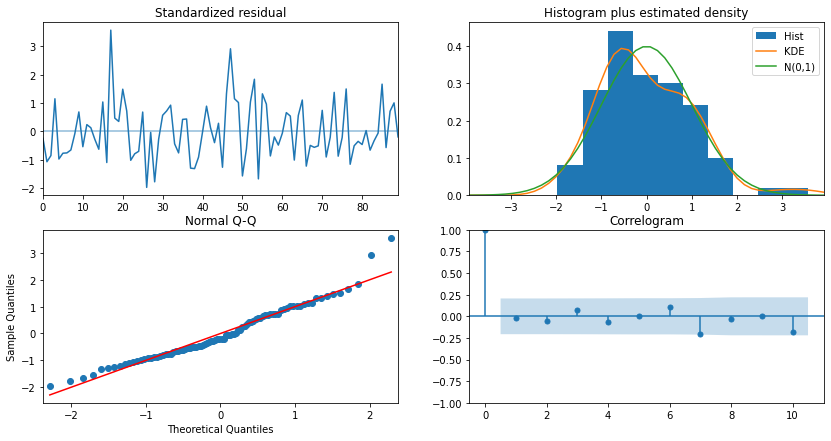


These are the diagnostics plots of the topic 'support system':



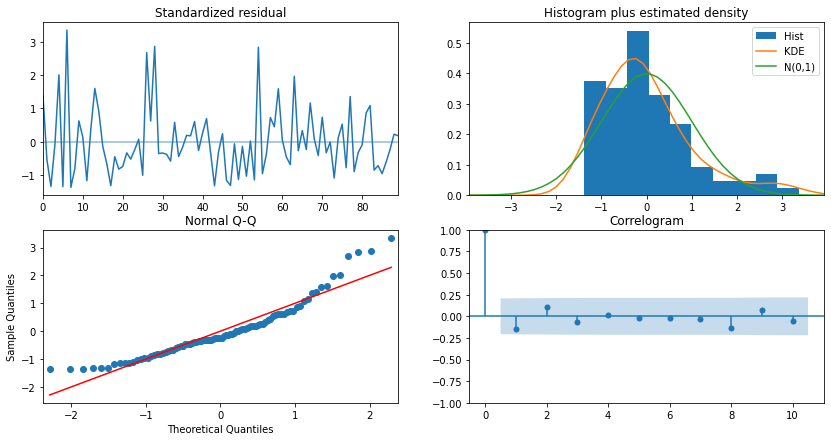


These are the diagnostics plots of the topic 'politics':



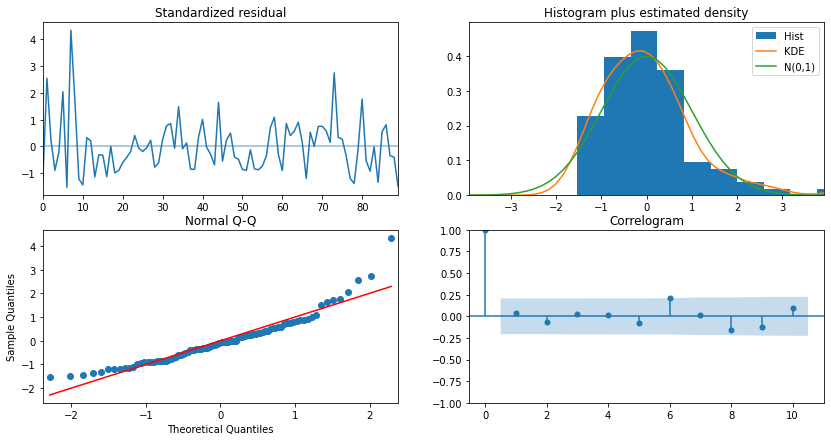


These are the diagnostics plots of the topic 'international role':



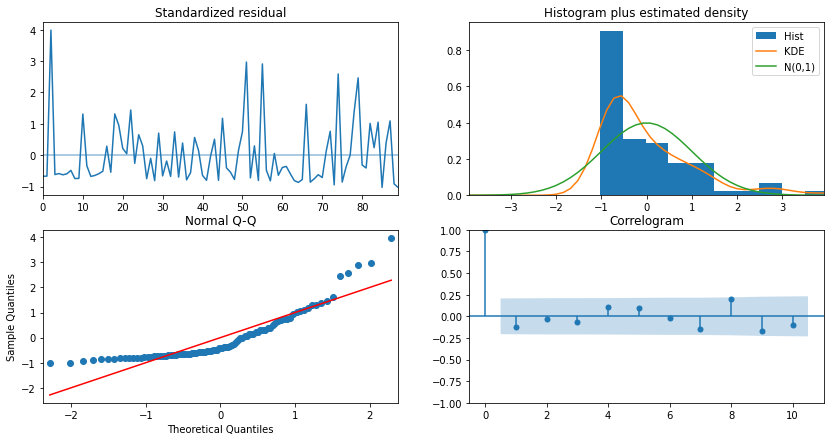


These are the diagnostics plots of the topic 'defence':



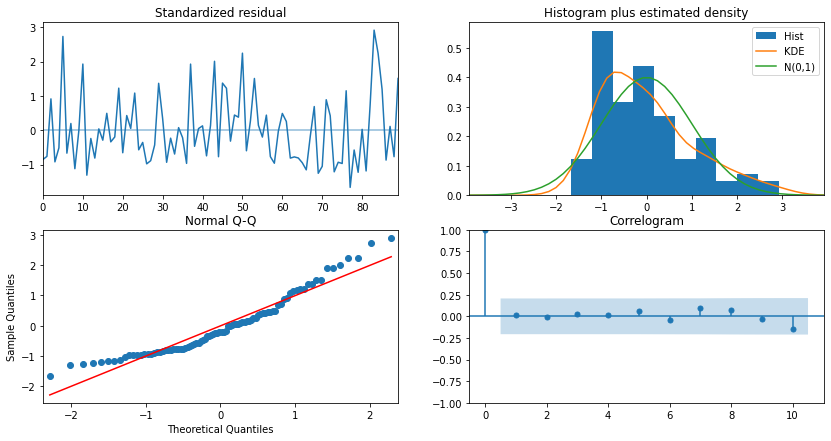


These are the diagnostics plots of the topic 'american dream':



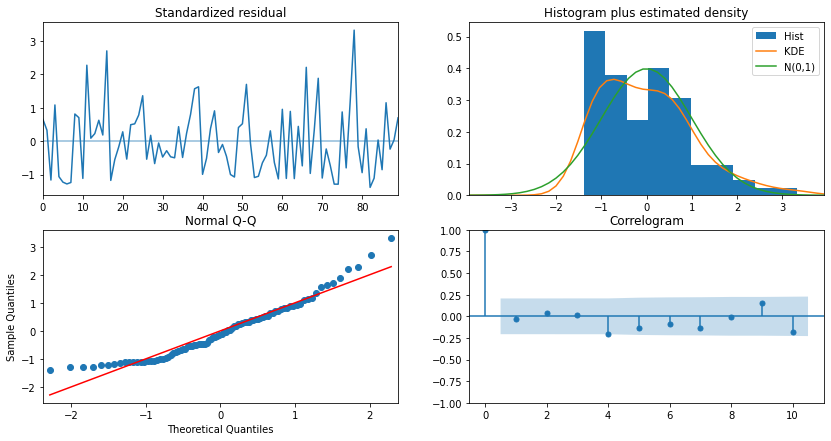

In [14]:
# show diagnostics plots for each topic
i = 0
for model in models_train:
    print("\nThese are the diagnostics plots of the topic '" + topic_names[i] + "':\n")
    model.plot_diagnostics()
    plt.show()
    i = i + 1

## Results

In [15]:
# standardise predictors in entire data set
time_series_df_standardised = time_series_df.copy()
time_series_df_standardised.iloc[:, number_topics:] = standardise_predictors(time_series_df_standardised.
                                                                             iloc[:, number_topics:])

In [16]:
# extract p, d and q from model with train data
pdq = []
for model in models_train:
    pdq.append(model.order)
    
# run time series analysis with entire data set using p, d, q from trained model
def time_series_entire(data_set, predictors):
    i = 0
    models_entire = []
    
    for column in data_set.columns[:number_topics]:
        model = ARIMA(data_set[column], 
                      order = pdq[i], 
                      exog = data_set[predictors])
    
        models_entire.append(model)
    
        i = i + 1
    
    return models_entire

In [17]:
models_entire = time_series_entire(time_series_df_standardised, predictors)

In [18]:
# extract coefficients and p-values for each topic
def coef_pvalue(models):
    i = 0
    for model in models:
        model_fit = model.fit()
        # write p-values and coefficients to data frames
        pvalues = pd.DataFrame(model_fit.pvalues)
        coef = pd.DataFrame(model_fit.params)
    
        # merge coefficients with p-values
        results = pd.merge(coef, pvalues, left_index = True, right_index = True)
        results.columns = ['coef', 'pvalues']
    
        # print output
        print("\nThis is the output of the time series analysis for the topic '" + str(topic_names[i]) + "':\n")
    
        print(results.round(4))
    
        i = i + 1

In [19]:
# print output for each topic
coef_pvalue(models_entire)


This is the output of the time series analysis for the topic 'labour market':

                  coef  pvalues
const          16.4293   0.0000
unemployment    4.5250   0.0793
oil            -0.8392   0.7022
stocks         -3.7536   0.1260
ma.L1           0.2133   0.0195
sigma2        204.0203   0.0000

This is the output of the time series analysis for the topic 'support system':

                  coef  pvalues
const          25.9821   0.0000
unemployment   -1.0042   0.6472
oil             2.1108   0.4114
stocks         -3.3204   0.1587
sigma2        376.1837   0.0000

This is the output of the time series analysis for the topic 'politics':

                  coef  pvalues
const          20.1656   0.0000
unemployment   -4.5896   0.0289
oil            -1.0043   0.5820
stocks          0.8854   0.6194
sigma2        222.0784   0.0000

This is the output of the time series analysis for the topic 'international role':

                  coef  pvalues
const          10.0297   0.0000
unemplo